In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from datetime import datetime, timedelta
import pytz
from sklearn.linear_model import LinearRegression

In [46]:
def fetch_price_data(ticker, start_date, end_date):
    """Fetch historical price data for a given ticker"""
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            raise ValueError(f"No data found for {ticker} between {start_date} and {end_date}")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [58]:
def calculate_z_score(series, window=20):
    """Calculate z-scores for a time series"""
    # Convert to Series if needed
    if isinstance(series, pd.DataFrame):
        if series.shape[1] == 1:
            series = series.squeeze()  # Convert single-column DataFrame to Series
        else:
            raise ValueError("DataFrame input must have exactly one column")
    elif not isinstance(series, pd.Series):
        series = pd.Series(series.squeeze()) if hasattr(series, 'squeeze') else pd.Series(series)
    
    if len(series) < window:
        raise ValueError(f"Series length ({len(series)}) must be >= window size ({window})")
    
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    z_score = (series - rolling_mean) / rolling_std
    return z_score

In [55]:
def mean_reversion_signal(z_score, entry_threshold=1.5, exit_threshold=0.5):
    """Generate trading signals based on z-score"""
    if not isinstance(z_score, pd.Series):
        z_score = pd.Series(z_score)
    
    signals = pd.Series(0, index=z_score.index)
    
    # Short when z-score is high (overvalued)
    signals[z_score > entry_threshold] = -1
    
    # Long when z-score is low (undervalued)
    signals[z_score < -entry_threshold] = 1
    
    # Exit positions
    signals[(z_score < exit_threshold) & (signals.shift(1) == -1)] = 0
    signals[(z_score > -exit_threshold) & (signals.shift(1) == 1)] = 0
    
    return signals

In [49]:
def backtest_strategy(price_data, signals, initial_capital=100000.0):
    """Backtest a trading strategy"""
    if not isinstance(price_data, pd.DataFrame) or 'Close' not in price_data.columns:
        raise ValueError("price_data must be a DataFrame with 'Close' column")
    
    backtest = pd.DataFrame(index=signals.index)
    backtest['Close'] = price_data['Close']
    backtest['Signal'] = signals
    
    # Calculate positions (maintain until signal changes)
    backtest['Position'] = signals.replace(0, method='ffill').fillna(0)
    
    # Calculate returns
    backtest['Returns'] = backtest['Close'].pct_change()
    backtest['Strategy_Returns'] = backtest['Position'].shift(1) * backtest['Returns']
    
    # Calculate equity curve
    backtest['Equity'] = (1 + backtest['Strategy_Returns']).cumprod() * initial_capital
    
    # Calculate drawdowns
    backtest['Peak'] = backtest['Equity'].cummax()
    backtest['Drawdown'] = (backtest['Equity'] - backtest['Peak']) / backtest['Peak']
    
    return backtest

In [50]:
def calculate_performance_metrics(backtest):
    """Calculate performance metrics for a backtest"""
    returns = backtest['Strategy_Returns'].dropna()
    if len(returns) == 0:
        raise ValueError("No valid returns to calculate metrics")
    
    metrics = {}
    metrics['Total Return'] = backtest['Equity'].iloc[-1] / backtest['Equity'].iloc[0] - 1
    
    # Annualized metrics
    trading_days = 252
    n_days = len(returns)
    n_years = n_days / trading_days
    
    metrics['Annualized Return'] = (1 + metrics['Total Return']) ** (1/n_years) - 1
    metrics['Annualized Volatility'] = returns.std() * np.sqrt(trading_days)
    
    # Risk-adjusted metrics
    risk_free_rate = 0.02
    metrics['Sharpe Ratio'] = (metrics['Annualized Return'] - risk_free_rate) / metrics['Annualized Volatility']
    
    # Drawdown metrics
    metrics['Max Drawdown'] = backtest['Drawdown'].min()
    
    # Trade metrics
    position_changes = backtest['Position'].diff().abs() > 0
    trade_returns = backtest['Strategy_Returns'][position_changes]
    
    if len(trade_returns) > 0:
        metrics['Win Rate'] = (trade_returns > 0).mean()
        metrics['Profit Factor'] = trade_returns[trade_returns > 0].sum() / abs(trade_returns[trade_returns < 0].sum())
    else:
        metrics['Win Rate'] = 0
        metrics['Profit Factor'] = 0
    
    return metrics

In [51]:
def plot_backtest_results(backtest, ticker, window, entry, exit):
    """Plot backtest results"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # Price and positions
    ax1.plot(backtest['Close'], label='Price')
    ax1.set_title(f'{ticker} Mean Reversion Strategy (Window={window}, Entry={entry}, Exit={exit})')
    
    # Add position shading
    for i in range(1, len(backtest)):
        if backtest['Position'].iloc[i] == 1:
            ax1.axvspan(backtest.index[i-1], backtest.index[i], color='green', alpha=0.1)
        elif backtest['Position'].iloc[i] == -1:
            ax1.axvspan(backtest.index[i-1], backtest.index[i], color='red', alpha=0.1)
    
    # Equity curve
    ax2.plot(backtest['Equity'], label='Equity', color='green')
    ax2.set_title('Equity Curve')
    
    # Drawdown
    ax3.plot(backtest['Drawdown'], label='Drawdown', color='red')
    ax3.set_title('Drawdown')
    ax3.axhline(0, color='black', linestyle='--')
    
    plt.tight_layout()
    return fig

In [65]:
def main():
    """Main execution function"""
    try:
        # Parameters
        ticker = 'AAPL'
        start_date = '2020-01-01'
        end_date = '2024-03-31'
        window = 20
        entry_threshold = 1.5
        exit_threshold = 0.5
        
        # Fetch data
        price_data = fetch_price_data(ticker, start_date, end_date)
        if price_data is None or price_data.empty:
            print("No data retrieved - check your ticker and date range")
            return
        
        # Ensure we have a Series for Close prices
        close_prices = price_data['Close']
        if isinstance(close_prices, pd.DataFrame):
            close_prices = close_prices.squeeze()  # Convert to Series if single-column DataFrame
        elif not isinstance(close_prices, pd.Series):
            close_prices = pd.Series(close_prices.squeeze()) if hasattr(close_prices, 'squeeze') else pd.Series(close_prices)
        
        # Calculate z-scores
        z_score = calculate_z_score(close_prices, window)
        
        # Generate signals
        signals = mean_reversion_signal(z_score, entry_threshold, exit_threshold)
        
        # Backtest strategy
        backtest = backtest_strategy(price_data, signals)
        
        # Calculate metrics
        metrics = calculate_performance_metrics(backtest)
        
        # Print results
        print("\nPerformance Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
        
        # Plot results
        fig = plot_backtest_results(backtest, ticker, window, entry_threshold, exit_threshold)
        plt.show()
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()

[*********************100%***********************]  1 of 1 completed



Performance Metrics:
Total Return: nan
Annualized Return: nan
Annualized Volatility: 0.3276
Sharpe Ratio: nan
Max Drawdown: -0.6478
Win Rate: 0.9667
Profit Factor: inf


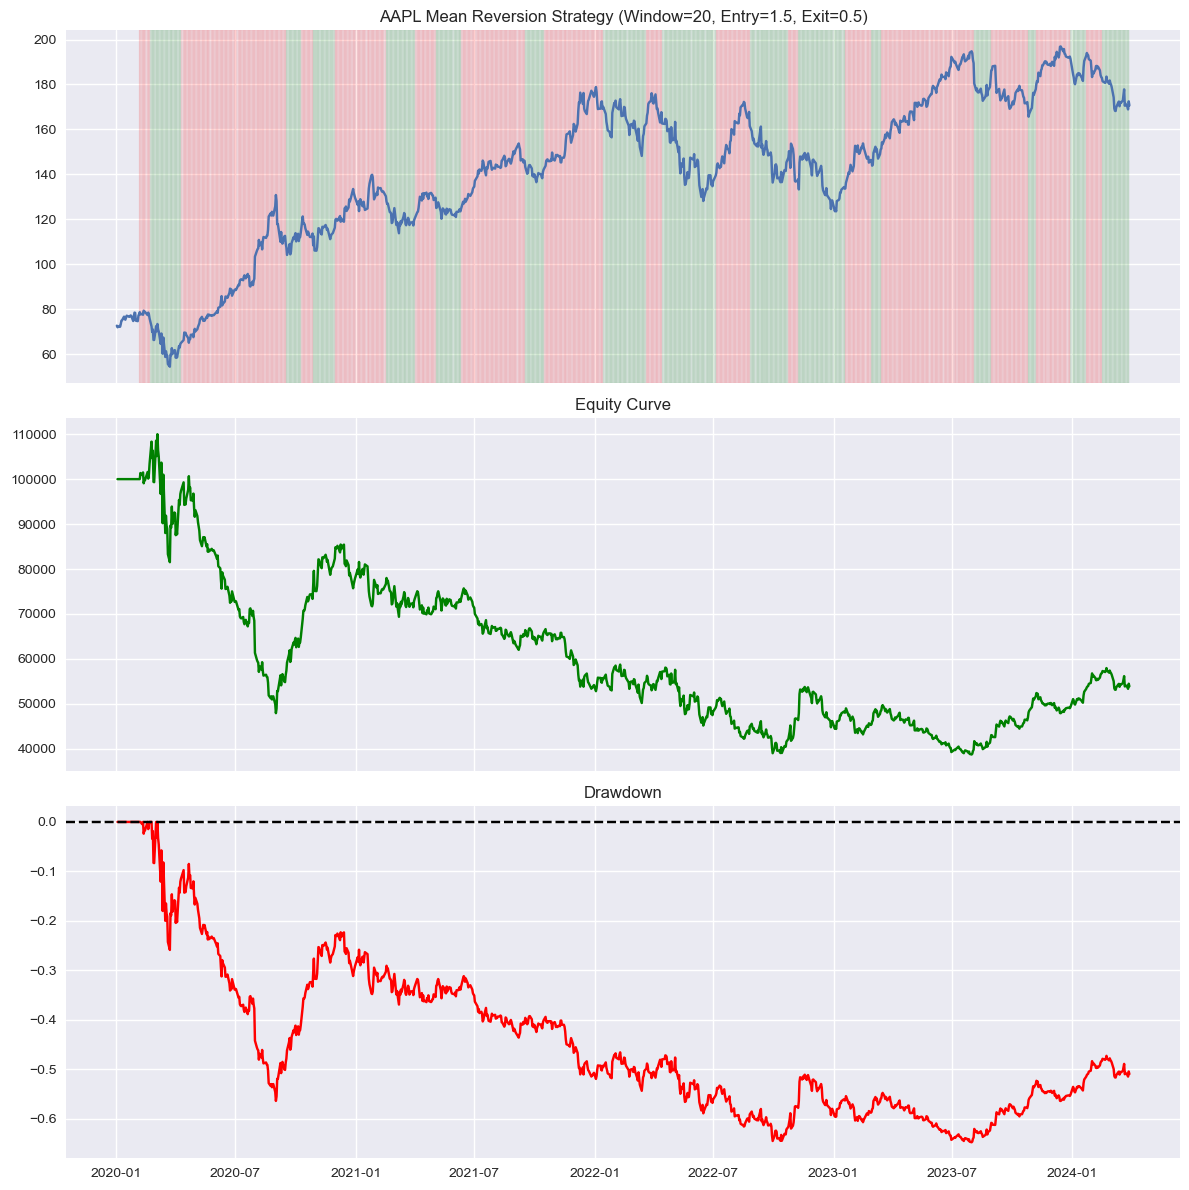

In [66]:
if __name__ == "__main__":
    main()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LinearRegression

In [2]:
def fetch_price_data(ticker, start_date, end_date):
    """Fetch historical price data for a given ticker"""
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            raise ValueError(f"No data found for {ticker} between {start_date} and {end_date}")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [3]:
def calculate_z_score(series, window=20):
    """Calculate z-scores for a time series"""
    if isinstance(series, pd.DataFrame):
        if series.shape[1] == 1:
            series = series.squeeze()
        else:
            raise ValueError("DataFrame input must have exactly one column")
    elif not isinstance(series, pd.Series):
        series = pd.Series(series.squeeze()) if hasattr(series, 'squeeze') else pd.Series(series)

    if len(series) < window:
        raise ValueError(f"Series length ({len(series)}) must be >= window size ({window})")
    
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    z_score = (series - rolling_mean) / rolling_std
    return z_score

In [4]:
def mean_reversion_signal(z_score, entry_threshold=1.5, exit_threshold=0.5):
    """Generate trading signals based on z-score"""
    if not isinstance(z_score, pd.Series):
        z_score = pd.Series(z_score)

    signals = pd.Series(0, index=z_score.index)

    long = z_score < -entry_threshold
    short = z_score > entry_threshold
    exit_long = z_score > -exit_threshold
    exit_short = z_score < exit_threshold

    position = 0
    for i in range(len(z_score)):
        if position == 0:
            if long[i]:
                position = 1
            elif short[i]:
                position = -1
        elif position == 1:
            if exit_long[i]:
                position = 0
        elif position == -1:
            if exit_short[i]:
                position = 0
        signals.iloc[i] = position

    return signals

In [5]:
def backtest_strategy(price_data, signals, initial_capital=100000.0):
    """Backtest a trading strategy"""
    if not isinstance(price_data, pd.DataFrame) or 'Close' not in price_data.columns:
        raise ValueError("price_data must be a DataFrame with 'Close' column")
    
    backtest = pd.DataFrame(index=signals.index)
    backtest['Close'] = price_data['Close']
    backtest['Signal'] = signals
    backtest['Position'] = signals.replace(0, np.nan).ffill().fillna(0)
    backtest['Returns'] = backtest['Close'].pct_change()
    backtest['Strategy_Returns'] = backtest['Position'].shift(1) * backtest['Returns']
    backtest['Equity'] = (1 + backtest['Strategy_Returns']).cumprod() * initial_capital
    backtest['Peak'] = backtest['Equity'].cummax()
    backtest['Drawdown'] = (backtest['Equity'] - backtest['Peak']) / backtest['Peak']
    return backtest

In [6]:
def calculate_performance_metrics(backtest):
    """Calculate performance metrics for a backtest"""
    returns = backtest['Strategy_Returns'].dropna()
    if len(returns) == 0:
        raise ValueError("No valid returns to calculate metrics")
    
    metrics = {}
    metrics['Total Return'] = backtest['Equity'].iloc[-1] / backtest['Equity'].iloc[0] - 1
    
    trading_days = 252
    n_days = len(returns)
    n_years = n_days / trading_days
    metrics['Annualized Return'] = (1 + metrics['Total Return']) ** (1/n_years) - 1
    metrics['Annualized Volatility'] = returns.std() * np.sqrt(trading_days)
    
    risk_free_rate = 0.02
    metrics['Sharpe Ratio'] = (metrics['Annualized Return'] - risk_free_rate) / metrics['Annualized Volatility']
    metrics['Max Drawdown'] = backtest['Drawdown'].min()
    
    position_changes = backtest['Position'].diff().abs() > 0
    trade_returns = backtest['Strategy_Returns'][position_changes]
    
    if len(trade_returns) > 0:
        metrics['Win Rate'] = (trade_returns > 0).mean()
        loss = abs(trade_returns[trade_returns < 0].sum())
        metrics['Profit Factor'] = trade_returns[trade_returns > 0].sum() / loss if loss != 0 else np.nan
    else:
        metrics['Win Rate'] = np.nan
        metrics['Profit Factor'] = np.nan
    
    return metrics

In [7]:
def plot_backtest_results(backtest, ticker, window, entry, exit):
    """Plot backtest results"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    ax1.plot(backtest['Close'], label='Price', color='blue')
    ax1.set_title(f'{ticker} Mean Reversion Strategy (Window={window}, Entry={entry}, Exit={exit})')
    ax1.legend()

    for i in range(1, len(backtest)):
        if backtest['Position'].iloc[i] == 1:
            ax1.axvspan(backtest.index[i-1], backtest.index[i], color='green', alpha=0.1)
        elif backtest['Position'].iloc[i] == -1:
            ax1.axvspan(backtest.index[i-1], backtest.index[i], color='red', alpha=0.1)

    ax2.plot(backtest['Equity'], label='Equity', color='green')
    ax2.set_title('Equity Curve')
    ax2.legend()

    ax3.plot(backtest['Drawdown'], label='Drawdown', color='red')
    ax3.set_title('Drawdown')
    ax3.axhline(0, color='black', linestyle='--')
    ax3.legend()

    plt.tight_layout()
    return fig

In [8]:
def main():
    """Main execution function"""
    try:
        # Parameters
        ticker = 'AAPL'
        start_date = '2020-01-01'
        end_date = '2024-03-31'
        window = 20
        entry_threshold = 1.5
        exit_threshold = 0.5

        # Fetch data
        price_data = fetch_price_data(ticker, start_date, end_date)
        if price_data is None or price_data.empty:
            print("No data retrieved - check your ticker and date range")
            return

        close_prices = price_data['Close']
        if isinstance(close_prices, pd.DataFrame):
            close_prices = close_prices.squeeze()
        elif not isinstance(close_prices, pd.Series):
            close_prices = pd.Series(close_prices.squeeze()) if hasattr(close_prices, 'squeeze') else pd.Series(close_prices)

        z_score = calculate_z_score(close_prices, window)
        signals = mean_reversion_signal(z_score, entry_threshold, exit_threshold)
        backtest = backtest_strategy(price_data, signals)
        metrics = calculate_performance_metrics(backtest)

        print("\nPerformance Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, (int, float, np.float64)) else f"{k}: {v}")

        fig = plot_backtest_results(backtest, ticker, window, entry_threshold, exit_threshold)
        plt.show()

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/var/folders/71/0hnjxlbj1k93ry1fd_9c57200000gn/T/ipykernel_29094/340403776.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if long[i]:
/var/folders/71/0hnjxlbj1k93ry1fd_9c57200000gn/T/ipykernel_29094/340403776.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif short[i]:
/var/folders/71/0hnjxlbj1k93ry1fd_9c57200000gn/T/ipykernel_29094/340403776.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access


Performance Metrics:
Total Return: nan
Annualized Return: nan
Annualized Volatility: 0.3276
Sharpe Ratio: nan
Max Drawdown: -0.6478
Win Rate: 0.9667
Profit Factor: nan


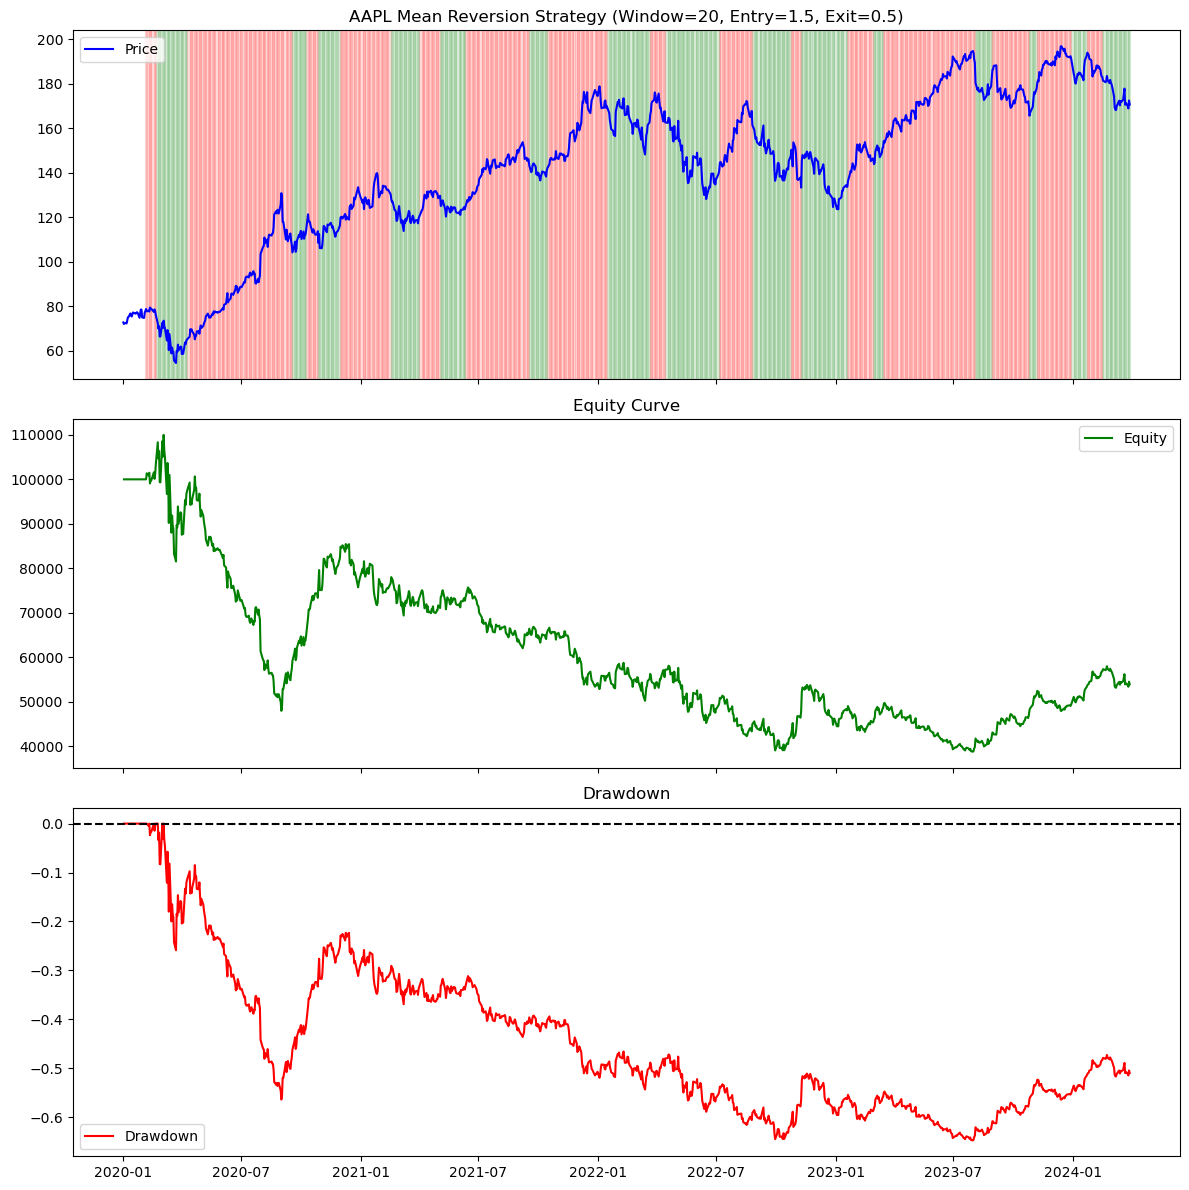

In [9]:
if __name__ == "__main__":
    main()